# SMS Spam Detection 

Goal of this notebook is to test different well-known classifiers with a plethora of features and see how they perform on the given dataset

### Import Libraries


In [1]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation and analysis
import pandas as pd
# Stemmer and Stopwords corpus
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
# For basic cleaning and data preprocessing 
import re
import string 

%matplotlib inline

### Inspecting the dataset



Read the data using pandas' read_csv method 

In [2]:
DATAPATH = 'data/spam.csv'
df = pd.read_csv(DATAPATH, encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [3]:
# Shape of our data
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Have a look on the data


In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message" respectively

In [5]:
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
df.rename(columns = {'v1':'label','v2':'message'}, inplace=True)

Also drop any row which has any NaN value

In [6]:
df.dropna(inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Target count for data


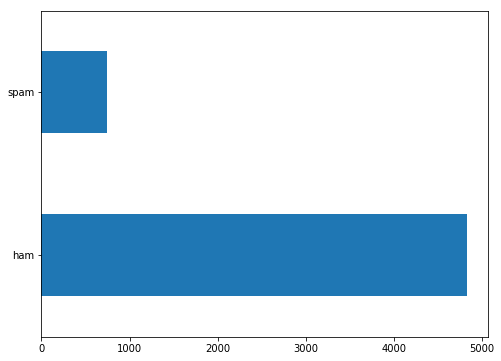

In [7]:
df['label'].value_counts().plot(kind='barh', figsize=(8, 6))

Vizualize data distribution using pie chart


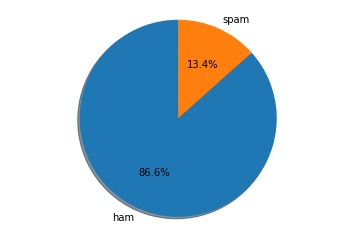

In [8]:
plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Have a look into the data grouped by into labels 'ham' or 'spam'


In [9]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's see how a ham and a spam sms look like

In [10]:
# Pick at random a ham sms 
df.loc[df['label'] == 'ham'].sample()

,label,message
2321,ham,Ok...


In [11]:
# Pick at random a spam sms 
df.loc[df['label'] == 'spam'].sample()

,label,message
3124,spam,1st wk FREE! Gr8 tones str8 2 u each wk. Txt N...


### Text preprocessing

Let's create new data frame. We'll need a copy later on

In [12]:
text_feat = df['message'].copy()

In [13]:
# Let's print the text before preprocessing step
print(text_feat)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
5       FreeMsg Hey there darling it's been 3 week's n...
6       Even my brother is not like to speak with me. ...
7       As per your request 'Melle Melle (Oru Minnamin...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
10      I'm gonna be home soon and i don't want to tal...
11      SIX chances to win CASH! From 100 to 20,000 po...
12      URGENT! You have won a 1 week FREE membership ...
13      I've been searching for the right words to tha...
14                    I HAVE A DATE ON SUNDAY WITH WILL!!
15      XXXMobileMovieClub: To use your credit, click ...
16                             Oh k...i'm watching here:)
17      Eh u r

With the first glance it's easy to determine whether a sms is ham or spam

Now define our text precessing function.

In [14]:
def text_process(text):
    # remove punctuation 
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [15]:
text_feat = text_feat.apply(text_process)

In [16]:
print(text_feat)

0       Go until jurong point crazy Available only in ...
1                                 Ok lar Joking wif u oni
2       Free entry in 2 a wkly comp to win FA Cup fina...
3             U dun say so early hor U c already then say
4       Nah I dont think he goes to usf he lives aroun...
5       FreeMsg Hey there darling its been 3 weeks now...
6       Even my brother is not like to speak with me T...
7       As per your request Melle Melle Oru Minnaminun...
8       WINNER As a valued network customer you have b...
9       Had your mobile 11 months or more U R entitled...
10      Im gonna be home soon and i dont want to talk ...
11      SIX chances to win CASH From 100 to 20000 poun...
12      URGENT You have won a 1 week FREE membership i...
13      Ive been searching for the right words to than...
14                      I HAVE A DATE ON SUNDAY WITH WILL
15      XXXMobileMovieClub To use your credit click th...
16                                   Oh kim watching here
17      Eh u r